# Setence Embedding

In this notebook, we will use pre-trained models - BERT - to generate sentence embeddings. The key library we will use is `sentence-transformers`. Here is the [official documentation](https://www.sbert.net/index.html). Over the last year, many document retrieval and semantic search applications have been built using this library, such as [this one](https://github.com/naity/PaperGPT).

Recently, some researchers have used `JAX` to speed up the inference of BERT models. Some new models also have better performances, however, we will not cover them in this notebook as it needs one to do a through survey of the latest models.

## Get to know sentence-transformers

We will use a simple example to show how to use `sentence-transformers` to generate sentence embeddings. When you use the library, the foremost thing you need to do is to decide __which models you want to use__. Please read the [official documentation](https://www.sbert.net/docs/pretrained_models.html) to get to know the available models.

In [1]:
import numpy as np
import pandas as pd


from tqdm import tqdm
from pyspark.sql import SparkSession
from sentence_transformers import SentenceTransformer, util

/home/michael/Github/ai-powered-search/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# intialize the model
# we will use a base model that is trained on NLI (Natural Language Inference) data
# this is just a demonstration, you can use any model that fits your needs
model = SentenceTransformer('bert-base-nli-mean-tokens')
model

/home/michael/Github/ai-powered-search/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [3]:
sentences = [
    "the fifty mannequin heads floating in the pool kind of freaked them out",
    "she swore she just saw her sushi move",
    "he embraced his new life as an eggplant",
    "my dentist tells me that chewing bricks is very bad for your teeth",
    "the dental specialist recommended an immediate stop to flossing with construction materials"
]

embeddings = model.encode(sentences)

embeddings.shape

(5, 768)

In [4]:
sim = np.zeros((len(sentences), len(sentences)))

for i in range(len(sentences)):
    sim[i:,i] = util.cos_sim(embeddings[i], embeddings[i:])

sim

array([[1.00000012, 0.        , 0.        , 0.        , 0.        ],
       [0.40914297, 1.        , 0.        , 0.        , 0.        ],
       [0.10909007, 0.44547975, 1.00000012, 0.        , 0.        ],
       [0.50074863, 0.30693936, 0.20791636, 1.        , 0.        ],
       [0.29936191, 0.38607201, 0.28499255, 0.63849491, 1.        ]])

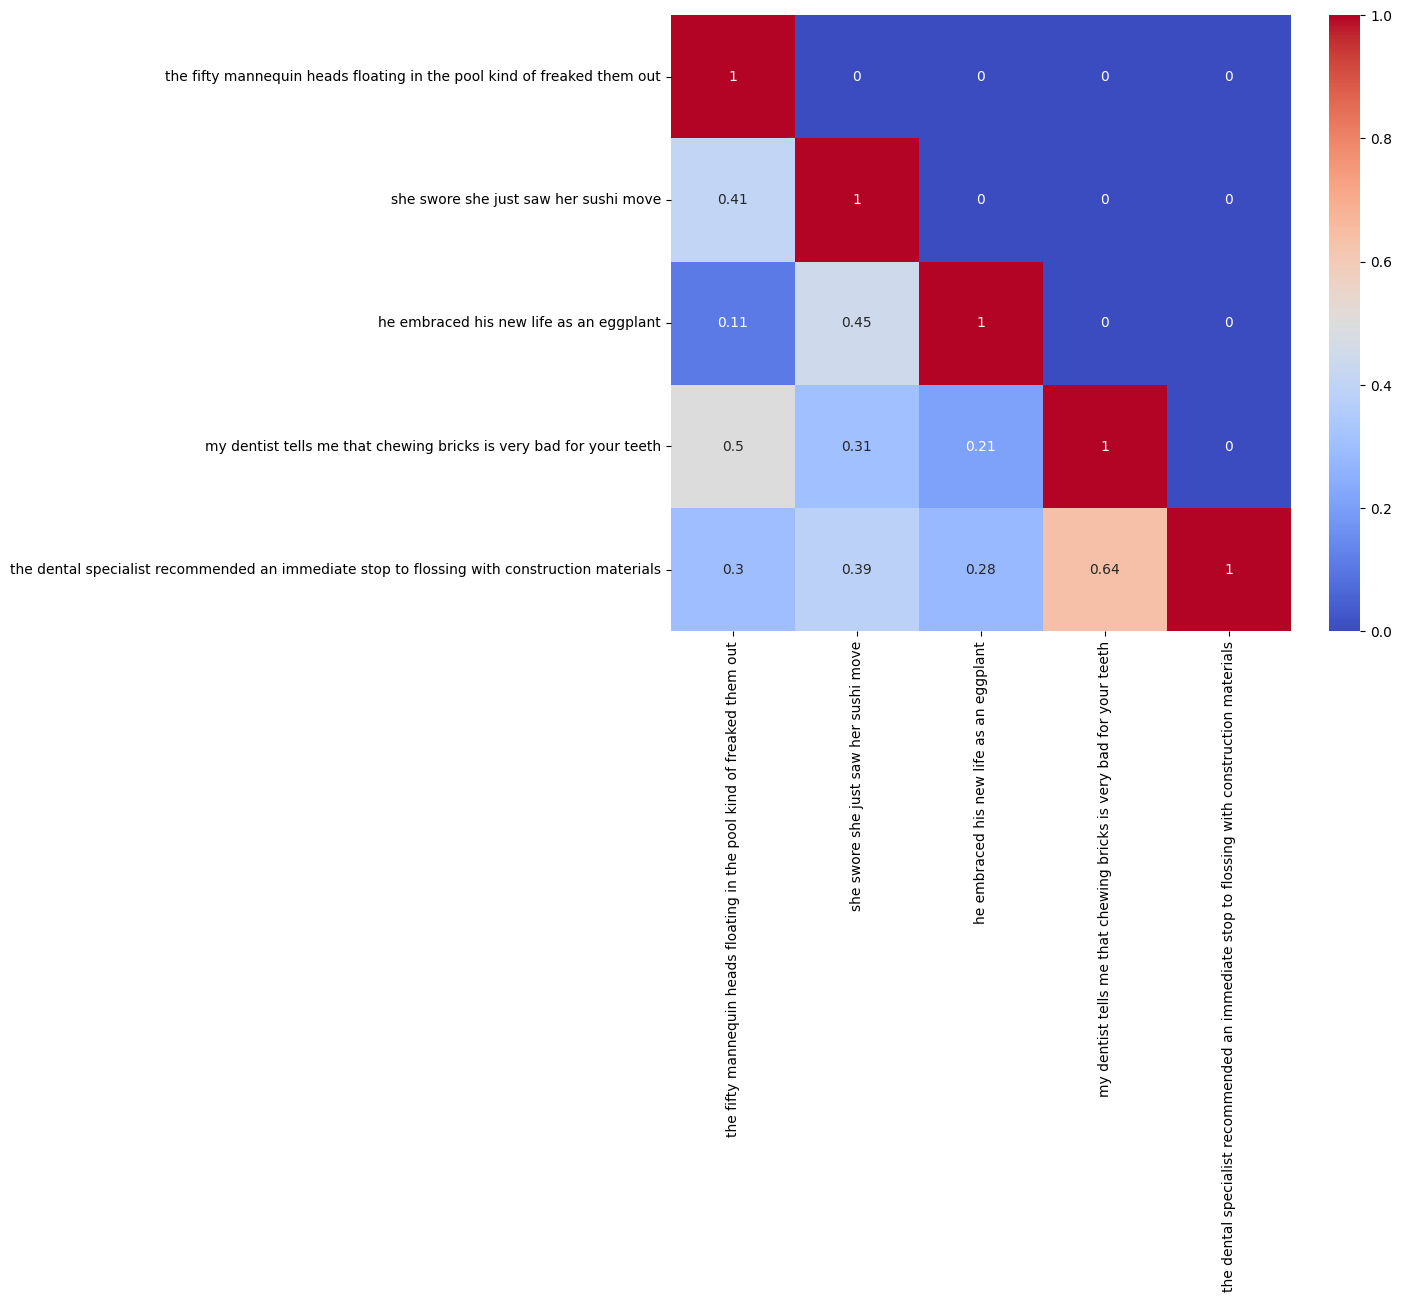

In [5]:
# visualize the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(sim, annot=True, cmap='coolwarm', xticklabels=sentences, yticklabels=sentences)
plt.show()

In [6]:
# we notice that sentence 4 and 5 are very similar
# let's check the cosine similarity between them

util.cos_sim(embeddings[3], embeddings[4])

tensor([[0.6385]])

In [7]:
# print the sentences
print(sentences[3])
print(sentences[4])

my dentist tells me that chewing bricks is very bad for your teeth
the dental specialist recommended an immediate stop to flossing with construction materials


**Remark**: If you only compare those two setences, you will notice that the only
connection between them is about the token 'dent', which is about dental care or dentist. The semantic similarity between them is not that high. However, _if we put them back into the corpus, the similarity between them is extradionary high_. This is the power of BERT.

In [8]:
# check setences to compare similarity
sentences

['the fifty mannequin heads floating in the pool kind of freaked them out',
 'she swore she just saw her sushi move',
 'he embraced his new life as an eggplant',
 'my dentist tells me that chewing bricks is very bad for your teeth',
 'the dental specialist recommended an immediate stop to flossing with construction materials']

## Load our parquet file

After doing ETL from `src/ETL.ipynb`, we have generated a parquet file. I saved it in my local machine and also uploaded it to google storage bucket. Here we will load the parquet file from my local machine.

In [5]:
# configure spark
spark = SparkSession.builder \
    .appName("Sentence Similarity") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "12g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/19 15:23:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# read parquet file
file_path = "../../data/20240519_training.parquet/"

df = spark.read.parquet(file_path)

In [7]:
df.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+--------------------+
| book_id|               title|             authors|         description|                link|         review_text|text_reviews_count|average_rating|            sentence|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+--------------------+
|   10000| The Face of Another|Kobo Abe;E. Dale ...|Like an elegantly...|https://www.goodr...|Face of Another i...|               118|          3.78|face of another i...|
|   10000| The Face of Another|Kobo Abe;E. Dale ...|Like an elegantly...|https://www.goodr...|This is by far my...|               118|          3.78|this is by far my...|
|10000114|The Devil's Grave...|           Anonymous|A exhilarating ad...|https://www.goodr...|Firstly, I wonder...|                 7|          3

### Choosing the right model

- The all-* models were trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models. The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality. 

- MS MARCO is a large scale information retrieval corpus that was created based on real user search queries using Bing search engine. The provided models can be used for semantic search, i.e., given keywords / a search phrase / a question, the model will find passages that are relevant for the search query.


I have a GPU on my local machine, so I will use it to speed up the inference. If you don't have a GPU, you can use google colab to run this notebook.

In [12]:
model = SentenceTransformer("msmarco-distilbert-base-tas-b")

query_embedding = model.encode("How big is London")
passage_embedding = model.encode([
    "London has 9,787,426 inhabitants at the 2011 census",
    "London is known for its finacial district",
])

print("Similarity:", util.cos_sim(query_embedding, passage_embedding))

/home/michael/Github/ai-powered-search/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Similarity: tensor([[0.8748, 0.7883]])


In [13]:
model = SentenceTransformer("msmarco-distilbert-dot-v5")

query_embedding = model.encode("How big is London")
passage_embedding = model.encode([
    "London has 9,787,426 inhabitants at the 2011 census",
    "London is known for its finacial district",
])

print("Similarity:", util.cos_sim(query_embedding, passage_embedding))

You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





Similarity: tensor([[0.8634, 0.7893]])


In [14]:
model = SentenceTransformer("msmarco-distilbert-base-tas-b")

query_embedding = model.encode("How big is London")
passage_embedding = model.encode([
    "London has 9,787,426 inhabitants at the 2011 census",
    "London is known for its finacial district",
], device="cuda")

print("Similarity:", util.dot_score(query_embedding, passage_embedding))

Similarity: tensor([[102.0256,  95.6696]])


As you can see that `msmarco-distilbert-dot-v5` is still in the development stage, so we will use `msmarco-distilbert-base-tas-b` instead.

## Train a model

Now, we will train a model using the `sentence-transformers` library. We will use the `msmarco-distilbert-base-tas-b` model to generate sentence embeddings. Even though we are using a pre-trained model, we still need to fine-tune it on our dataset. The fine-tuning process is quite simple, and the library provides a `SentenceTransformer` class to help us do that. 

One of the most important parameters is `max_seq_length`, which is the maximum length of the input sequence. The default value is 512, which is too large for our dataset. We will set it to 200. Of course, for the production environment, you have to test different values to find the best one.

In [3]:
model = SentenceTransformer("msmarco-distilbert-base-tas-b")
# that's the sentence transformer
print(model.max_seq_length)
# that's the underlying transformer
print(model[0].auto_model.config.max_position_embeddings)

512
512


### How to choose the maximum sequence length

The maximum sequence length is the maximum number of tokens that the model can process. If the input sequence is longer than this value, the model will truncate it. If the input sequence is shorter than this value, the model will pad it. The maximum sequence length is a hyperparameter that you need to tune. The default value is 512, which is too large for our dataset. We will set it to 257. 

From the `ETL.ipynb`, we know that most of reviews have around 500 words. Some of them have more than 1000 words. We also construct our sentences by concatenating the reviews, title, descrition, and authors, which means that we prioritize the content of the reviews.

In [8]:
final_model = SentenceTransformer("msmarco-distilbert-base-tas-b")
final_model.max_seq_length = 257
print(final_model.max_seq_length)

257


In [9]:
# check dimension of df
df.count()

1370919

As you can see that we have 1.3 million rows in out dataset, wihch is quite large. First, we will see how long does it take to train the model on a small subset of the dataset. If it does not too long, we will use the full dataset to train the model.

In [14]:
# sample 1% of the data
df_sample = df.sample(fraction=0.01, seed=42)

df_sample.count()

13866

In [15]:
df_sample.show(5)

+--------+--------------------+----------------+--------------------+--------------------+--------------------+------------------+--------------+--------------------+
| book_id|               title|         authors|         description|                link|         review_text|text_reviews_count|average_rating|            sentence|
+--------+--------------------+----------------+--------------------+--------------------+--------------------+------------------+--------------+--------------------+
|10215672|The Blood Royal (...|Barbara Cleverly|A story of murder...|https://www.goodr...|Good bones of a p...|                86|          3.62|good bones of a p...|
|10254376|The Immaculate Co...|David R. Surette|                    |https://www.goodr...|                NULL|                 1|          4.33|the immaculate co...|
| 1031348|Blood Brothers (S...|    Nora Roberts|Every seven years...|https://www.goodr...|Nora Roberts is n...|                16|          4.15|nora roberts is n...

In [16]:
# construct corpus and make it a list
corpus_sample = df_sample.select("sentence").rdd.flatMap(lambda x: x).collect()

print(corpus_sample[:5])

["good bones of a plot buried under endless awful dialogue.[sep]the blood royal (joe sandilands #9)[sep]a story of murder, mystery and espionage (with a dash of romance) set in london in the long, hot summer of 1922, against the backdrop the romanov murders and the disappearance of the tsar's fortune.\na beautiful and traumatized young russian woman turns herself in at the british consulate in russia, begging to be sent to relatives in england and rescued from the mysterious tragedies of her past. but is she what she seems, or is she a deadly spy on a secret mission?[sep]barbara cleverly", "the immaculate conception mothers' club: poems[sep][sep]david r. surette", "nora roberts is no stephen king. parts of this book were just pointless - the dialogues were unbearable, and the characters just two-dimensional. i've never been a fan of the romance genre, and this is the first nora roberts book i've read, so i don't know if my expectations from the author were too high. the plot was very i

In [22]:
print(len(corpus_sample))

13866


In [17]:
corpus_sample_embeddings = final_model.encode(
    corpus_sample,
    show_progress_bar=True,
    device="cuda",
    convert_to_numpy=False
)

Batches: 100%|██████████| 434/434 [00:22<00:00, 18.97it/s]


In [24]:
# take a look at the first embedding
corpus_sample_embeddings[0].shape

torch.Size([768])

In [25]:
len(corpus_sample_embeddings)

13866

The dimenion for our sentence embeddings is 768. Since we have 13866 rows in our dataset, the matrix is in the shape of (13866, 768). It takes around 21 seconds to generate the sentence embeddings for the our sample dataset. If we use the full dataset, it will take around 20 minutes.

In [12]:
# show dimension of df
df.count()

1370919

### Create a small embedding dataset

After training our model, we will create a small embedding dataset to proceed with the next steps.

In [18]:
embedding_list = [x.tolist() for x in corpus_sample_embeddings]
len(embedding_list)

13866

In [19]:
df_sample.show(5)

+--------+--------------------+----------------+--------------------+--------------------+--------------------+------------------+--------------+--------------------+
| book_id|               title|         authors|         description|                link|         review_text|text_reviews_count|average_rating|            sentence|
+--------+--------------------+----------------+--------------------+--------------------+--------------------+------------------+--------------+--------------------+
|10215672|The Blood Royal (...|Barbara Cleverly|A story of murder...|https://www.goodr...|Good bones of a p...|                86|          3.62|good bones of a p...|
|10254376|The Immaculate Co...|David R. Surette|                    |https://www.goodr...|                NULL|                 1|          4.33|the immaculate co...|
| 1031348|Blood Brothers (S...|    Nora Roberts|Every seven years...|https://www.goodr...|Nora Roberts is n...|                16|          4.15|nora roberts is n...

In [21]:
# create a datarame from df_sample and embedding_list
# select "title", "author", "description", "link", "average_rating", "reviews_count"
# from df_sample and create dataframe
df_sample_emb = df_sample.select(
    "title", "authors", "description", "link", "average_rating", "text_reviews_count"
    ).toPandas()

In [22]:
df_sample_emb.shape

(13866, 6)

In [23]:
# add embeddings to the dataframe
df_sample_emb["embeddings"] = embedding_list

In [24]:
df_sample_emb.head()

,title,authors,description,link,average_rating,text_reviews_count,embeddings
0,The Blood Royal (Joe Sandilands #9),Barbara Cleverly,"A story of murder, mystery and espionage (with...",https://www.goodreads.com/book/show/10215672-t...,3.62,86,"[-0.15909264981746674, -0.1371365487575531, 0...."
1,The Immaculate Conception Mothers' Club: Poems,David R. Surette,,https://www.goodreads.com/book/show/10254376-t...,4.33,1,"[0.20239317417144775, -0.07957711070775986, 0...."
2,"Blood Brothers (Sign of Seven, #1)",Nora Roberts,"Every seven years, there comes a week in July ...",https://www.goodreads.com/book/show/1031348.Bl...,4.15,16,"[0.05845876783132553, 0.01633705385029316, 0.1..."
3,Quake,Richard Laymon,"'If you've missed Laymon, you've missed a trea...",https://www.goodreads.com/book/show/1053577.Quake,3.81,53,"[0.07258052378892899, -0.11186782270669937, 0...."
4,Just One More Day: A Memoir,Susan Lewis,"In 1960s Bristol, a family is overshadowed by ...",https://www.goodreads.com/book/show/10932.Just...,3.94,23,"[-0.391880601644516, -0.05829627811908722, -0...."


In [25]:
# create a new column called 'index'
df_sample_emb["index"] = df_sample_emb.index
df_sample_emb.head()

,title,authors,description,link,average_rating,text_reviews_count,embeddings,index
0,The Blood Royal (Joe Sandilands #9),Barbara Cleverly,"A story of murder, mystery and espionage (with...",https://www.goodreads.com/book/show/10215672-t...,3.62,86,"[-0.15909264981746674, -0.1371365487575531, 0....",0
1,The Immaculate Conception Mothers' Club: Poems,David R. Surette,,https://www.goodreads.com/book/show/10254376-t...,4.33,1,"[0.20239317417144775, -0.07957711070775986, 0....",1
2,"Blood Brothers (Sign of Seven, #1)",Nora Roberts,"Every seven years, there comes a week in July ...",https://www.goodreads.com/book/show/1031348.Bl...,4.15,16,"[0.05845876783132553, 0.01633705385029316, 0.1...",2
3,Quake,Richard Laymon,"'If you've missed Laymon, you've missed a trea...",https://www.goodreads.com/book/show/1053577.Quake,3.81,53,"[0.07258052378892899, -0.11186782270669937, 0....",3
4,Just One More Day: A Memoir,Susan Lewis,"In 1960s Bristol, a family is overshadowed by ...",https://www.goodreads.com/book/show/10932.Just...,3.94,23,"[-0.391880601644516, -0.05829627811908722, -0....",4


In [26]:
# save the dataframe to parquet file
current_date = pd.Timestamp.now().strftime("%Y%m%d")
df_sample_emb.to_parquet(f"../../data/{current_date}_embeddings.parquet",
                         engine="pyarrow",
                         compression="snappy")

## Train the model on the full dataset

After training the model on the small dataset, we will train the model on the full dataset. It takes around 20 minutes to train the model on the full dataset. After that, we will save the model to disk.

In [27]:
final_model = SentenceTransformer("msmarco-distilbert-base-tas-b")
final_model.max_seq_length = 257
print(final_model.max_seq_length)

/home/michael/Github/ai-powered-search/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


257


In [28]:
corpus = df.select("sentence").rdd.flatMap(lambda x: x).collect()
print(len(corpus))

1370919


In [29]:
print(corpus[:5])

["face of another is a kind of post-kafka take on the experiment gone wrong stories of wells and stevenson. abe sometimes sinks his narrative drive by fully realizing the artifice through which he is revealing his story, here it is the notebooks of the scientist who creates the titular object, written to his wife. this mirrors the structures of secret rendezvous and box man and in the final post-script of the wife echoes the finale of tanizaki's the key. the notebooks contain anecdotal philosophizing and scientific procedures, alongside manic confessions and visceral accounts of his dissociative panic, and accounts of folk tales and movies that reflect the book's themes. things start to pick in the second half as the narrator's eccentric behavior increases, his identity becomes frayed, and he literally begins haunting his own life. abe also continues his willingness to take a central metaphor and discuss from as many possible angles and permutations with a mix of profound, witty, silly

In [30]:
corpus_embeddings = final_model.encode(
    corpus,
    show_progress_bar=True,
    device="cuda",
    convert_to_numpy=False
)

Batches:  13%|█▎        | 5442/42842 [05:03<35:05, 17.77it/s]  